In [1]:
import os
import random
from datasets import load_dataset, Dataset
from tqdm import tqdm
import polars as pl
from concurrent.futures import ProcessPoolExecutor
import spacy
import numpy as np
from functools import partial
import re
from PIL import Image
import torch
import matplotlib.pyplot as plt


import torchvision
from torchvision.transforms.functional import InterpolationMode
from transformers import AutoTokenizer, AutoProcessor, AutoModelForSeq2SeqLM, AutoModel
import diffusers
from diffusers.image_processor import VaeImageProcessor
from diffusers import AutoencoderKL, DDPMScheduler

pl.Config.set_fmt_str_lengths(200)

/home/enric/projects/tiny_diffusion/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


polars.config.Config

In [2]:
import torch
torch.cuda.empty_cache()

In [5]:
x = torch.randn((1, 60, 768))
x.mean(1).shape

torch.Size([1, 768])

In [3]:
PATH = '/mnt/sd1tb/tinydiffusion/dataset_v1/'

In [7]:
num_canonical_nodes = 128 * 8
256 * 128 // num_canonical_nodes

32

In [4]:
vae = AutoencoderKL.from_pretrained('stabilityai/stable-diffusion-xl-base-1.0', subfolder='vae')

In [15]:
vae.encode(torch.randn((2, 3, 256, 256))).latent_dist.sample().shape

torch.Size([2, 4, 32, 32])

In [3]:
# df_all = pl.DataFrame()
# for i in tqdm(range(1, 5+1)):
#     list_dicts = pl.read_json(
#         PATH + f'ye-pop/ye-pop-{i}.json'
#     ).transpose()['column_0'].to_list()
#     df_yepop = pl.from_dicts(list_dicts)
#     df_all = pl.concat([df_all, df_yepop])

In [4]:
def show_image(df, idx=None):
    if idx is None:
        idx = random.randint(0, len(df))
    row = df[idx]
    path = row['path'][0]
    prompt = row['caption'][0]
    img = Image.open(path).convert('RGB').resize((256, 256))
    h, w = row['height'][0], row['width'][0]
    print(h, w)
    print(prompt)
    plt.figure(figsize=(8, 10))
    plt.imshow(img)
    # plt.title(prompt, {'fontsize': 14})
    plt.axis('off')
    return img

In [5]:
df_consolidated = pl.read_parquet(
    PATH + 'dataset_gold.parquet'
)
len(df_consolidated)

318249

892 1200
a dark and ominous scene with a large castle towering over the landscape. The castle is situated on top of a mountain, and the sky is cloudy and dark, creating a dramatic backdrop. The tower is illuminated by a light source, drawing attention to its imposing presence. There are several birds flying around the castle, adding to the eerie atmosphere. The overall style of the image is reminiscent of a fantasy or horror setting, with the castle serving as the central focus.


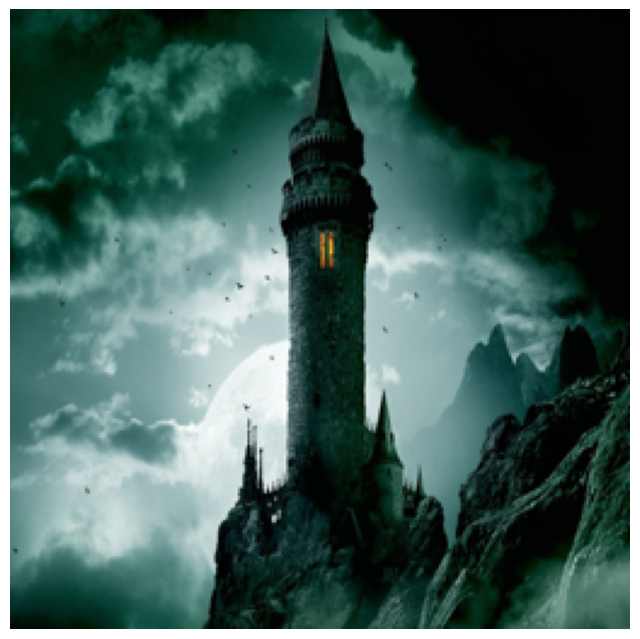

In [6]:
img = show_image(df_consolidated, idx=None)

In [56]:
# Use a pipeline as a high-level helper
from transformers import pipeline
os.environ["TRANSFORMERS_CACHE"] = "/home/mnt/sd1tb/cache/"
pipe = pipeline("image-classification", model="shadowlilac/aesthetic-shadow-v2", device="cuda")
pipe(img)

[{'label': 'lq', 'score': 0.501220703125},
 {'label': 'hq', 'score': 0.4987792670726776}]

In [47]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

# model = AutoModelForImageClassification.from_pretrained(
#     "miguelcarv/resnet-152-text-detector", torch_dtype=torch.float16,
# ).to("cuda")
# processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50", do_resize=False)

inputs = processor(img, return_tensors="pt").pixel_values.to("cuda")
with torch.inference_mode(), torch.cuda.amp.autocast():
    outputs = model(inputs)
outputs.logits.softmax(dim=1) 

In [45]:
from streaming import MDSWriter, LocalDataset, StreamingDataset, StreamingDataLoader
import base64 
import io

image_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Lambda(lambda img: img.convert('RGB')),
    torchvision.transforms.Resize(256, interpolation=InterpolationMode.BICUBIC),
    torchvision.transforms.RandomCrop(256),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5], [0.5]),
])

def base64_to_numpy(base64_str):
    decoded = base64.b64decode(base64_str)
    buffer = io.BytesIO(decoded)
    array = np.load(buffer)
    return array


class MosaicDataset(StreamingDataset):
    def __init__(self, local, batch_size=1, shuffle=False):
        super().__init__(local=local, batch_size=batch_size, predownload=8*batch_size, shuffle=shuffle)


    def __getitem__(self, idx):
        data = super().__getitem__(idx)
        # data['img'] = image_transforms(data['img'])
        # data['t5_pool'] = data['t5_pool'] #base64_to_numpy(data['t5_pool'])
        data['t5_output'] = data['t5_output']
        data['vae_output'] = data['vae_output']
        return data
    
dataset = MosaicDataset(local=PATH + 'dataset/train')
# dataset[0]['img']

/home/enric/projects/tiny_diffusion/.venv/lib/python3.12/site-packages/streaming/base/stream.py:461: ResourceWarning: unclosed file <_io.TextIOWrapper name='/mnt/sd1tb/tinydiffusion/dataset_v1/dataset/train/index.json' mode='r' encoding='UTF-8'>
  obj = json.load(open(filename))


In [34]:
dataset[0]['t5_output'].shape

(231, 768)

In [44]:
bs = 32
dataset = MosaicDataset(local=PATH + 'dataset/train', batch_size=bs, shuffle=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, pin_memory=True, num_workers=2, drop_last=True)
for batch in tqdm(dataloader):
    pass

# batch

/home/enric/projects/tiny_diffusion/.venv/lib/python3.12/site-packages/streaming/base/stream.py:461: ResourceWarning: unclosed file <_io.TextIOWrapper name='/mnt/sd1tb/tinydiffusion/dataset_v1/dataset/train/index.json' mode='r' encoding='UTF-8'>
  obj = json.load(open(filename))
  0%|          | 0/313 [00:00<?, ?it/s]

Because `num_canonical_nodes` was not specified, and `shuffle_algo` is py1e, it will default to be equal to physical nodes. Prior to Streaming v0.7.0, `num_canonical_nodes` defaulted to 64 * physical nodes.
Because `shuffle_block_size` was not specified, it will default to max(4_000_000 // num_canonical_nodes, 1 << 18) if num_canonical_nodes is not None, otherwise 262144. Prior to Streaming v0.7.0, `shuffle_block_size` defaulted to 262144.
100%|██████████| 313/313 [00:01<00:00, 163.77it/s]


In [25]:
batch['t5_output'].shape

torch.Size([32, 231, 768])

In [10]:
# vae = AutoencoderKL.from_pretrained("ostris/vae-kl-f8-d16", torch_dtype=torch.float16).to("cuda")
# print(vae.config.scaling_factor)
# _ = vae.requires_grad_(False)
# z = vae.encode(torch.Tensor(img).permute(2, 0, 1)[None].to("cuda")).latent_dist.sample()
# img_rec = vae.decode(z).sample

In [11]:
# tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pile-t5-base", use_fast=True)
# tokenizer.pad_token = tokenizer.bos_token
# model = AutoModelForSeq2SeqLM.from_pretrained("EleutherAI/pile-t5-base").to("cuda")
# _ = model.eval()
# model.requires_grad_(False)

In [12]:
captions = df_consolidated['caption'].to_list()

# caption_inputs = tokenizer(
#     captions[:32], max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt"
# )
# input_ids = caption_inputs["input_ids"].to("cuda")
# encoder_hidden_states = model(
#     input_ids=input_ids, 
#     decoder_input_ids=input_ids, 
#     return_dict=False, 
# )[0]

# model = AutoModel.from_pretrained("google/siglip-so400m-patch14-384", cache_dir='/mnt/sd1tb/cache').to("cuda")#.to(torch.float16)
# processor = AutoProcessor.from_pretrained("google/siglip-so400m-patch14-384", cache_dir='/mnt/sd1tb/cache')
# inputs = processor(text=captions[:32], images=None, padding="max_length", return_tensors="pt")

In [13]:

image_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Lambda(lambda img: img.convert('RGB')),
    torchvision.transforms.Resize(256, interpolation=InterpolationMode.BICUBIC),
    torchvision.transforms.RandomCrop(256),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5], [0.5]),
])

class Dataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pile-t5-base", use_fast=True)
        self.tokenizer.pad_token = self.tokenizer.bos_token

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe[idx, "path"]
        caption = self.dataframe[idx, "caption"]
        print(caption)
        image = Image.open(img_path)

        # Caption
        caption = self.tokenizer(
            caption, 
            truncation=True,
            max_length=77*3, 
            padding="max_length", 
            return_tensors="pt"
        )
        caption['input_ids'] = caption["input_ids"].squeeze()

        # Image
        if self.transform:
            image = self.transform(image)

        return {"image": image, "caption": caption}
    
dataset = Dataset(df_consolidated, transform=image_transforms)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, pin_memory=True, pin_memory_device="cuda:0")
for batch in dataloader:
    break

Mechanisms controlling DOC transport; Surface flow vs pipes vs groundwater Pippa Chapman, School of Geography University of Leeds water@leeds
Who are we? We are children of God. Our potential is unlimited. Image
2012 Honda Pilot for sale at Westland Auto Sales in Fresno CA
Luxury 5 Bedroom Villa with Pool and Sea Views in Pevero, Porto Cervo, sleeps 10
A Line V Neck Orange Long Prom Dress with Leg Slit cg5063
Custom Car Auto Sunshade Skull Astronaut In Spaceship HD-DT2181918-SS Auto Sunshade 57''x27.5''
Penguin™ Sunroom Kit Gray/Tan with Polycarbonate Roof 12' x 18' Solarium Gazebo Penguin Grey 12x18
New Thick velvet Sofa Cover Elasticity Non slip Couch Slipcover Universal Spandex Case for Stretch Sofa Cover 1/2/3/4 Seater
Angeleyes  Multi-layer Coating 2 Inches 26mm 32mm 40mm Eyepiece Telescope Accessories AngelMM
Image: A relative of an Australian victim of Malaysia Airlines jet MH17 touches a memorial that was unveiled outside Parliament House in Canberra, Australia, July 17, 2017
S

In [14]:
vae = AutoencoderKL.from_pretrained("ostris/vae-kl-f8-d16").to("cuda").to(torch.float16)
_ = vae.requires_grad_(False)

In [18]:
with torch.cuda.amp.autocast():
    z = vae.encode(batch['image'].to('cuda')).latent_dist.sample() * vae.config.scaling_factor
    rec = vae.decode(z / vae.config.scaling_factor).sample #/ vae.config.scaling_factor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


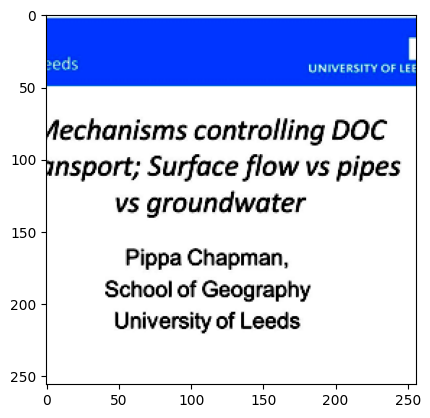

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1845703..1.4091797].


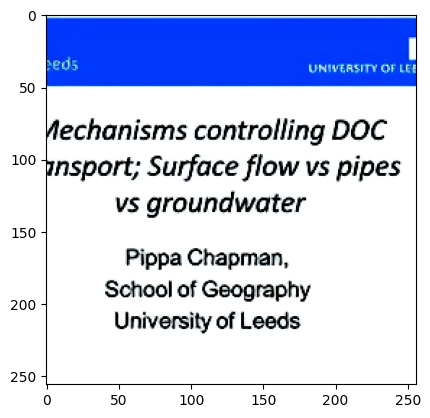

In [19]:
plt.imshow(batch['image'][0].permute(1, 2, 0)); plt.show();
plt.imshow(rec[0].float().permute(1, 2, 0).cpu());plt.show()

In [17]:
torch.cuda.empty_cache()
t5model = AutoModelForSeq2SeqLM.from_pretrained("EleutherAI/pile-t5-base").to("cuda").to(torch.float16)
t5model.requires_grad_(False)
t5_inputs = {k: v.to("cuda") for k, v in batch['caption'].items()}
with torch.cuda.amp.autocast(), torch.inference_mode():
    t5_outputs = t5model.encoder(**t5_inputs)[0]
mask = t5_inputs["attention_mask"].permute(0, 2, 1).expand(t5_outputs.shape)
t5_outputs = t5_outputs * mask

In [26]:
t5_inputs['attention_mask'].shape

torch.Size([32, 1, 231])